# This notebook contains the code for two case studies.

In [16]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterio.enums import Resampling
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import glob
import os
import re
from tqdm import tqdm

import pyproj
from pyproj import CRS, transform

from leafmap import leafmap

import ee
ee.Initialize()
import geemap

import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

import plotly.graph_objects as go

%matplotlib inline

# Case One: Mangrove

In [2]:
def get_latlon(geojson_file):
    """
    Function to extract latitude, longitude, and bounding box from a GeoJSON file.
    
    Args:
        geojson_file (str): Path to the GeoJSON file.
        
    Returns:
        tuple: A tuple containing latitude, longitude, and bounding box (latitude, longitude, bbox).
    """    
    gdf = gpd.read_file(geojson_file)
    bbox = gdf.total_bounds
    centroid = gdf.centroid.to_crs(gdf.crs)
    longitude = centroid.x[0]
    latitude = centroid.y[0]
    return latitude, longitude, bbox

def clip_raster_with_geojson(input_raster, output_raster, geojson_file):
    """
    Function to clip a raster using a GeoJSON file and save the clipped raster to a new file.
    
    Args:
        input_raster (str): Path to the input raster file.
        output_raster (str): Path to save the clipped raster file.
        geojson_file (str): Path to the GeoJSON file used for clipping.
    """
    # Open the GeoJSON file
    gdf = gpd.read_file(geojson_file)
    
    # Get the bounding box of the GeoJSON geometry
    bbox = gdf.total_bounds
    
    with rasterio.open(input_raster) as src:
        # Clip the raster using the GeoJSON geometry
        clipped_data, clipped_transform = mask(src, gdf.geometry, crop=True)
        
        # Update the metadata
        profile = src.profile
        profile.update({
            'height': clipped_data.shape[1],
            'width': clipped_data.shape[2],
            'transform': clipped_transform,
            'compress': 'lzw'
        })
        
        # Write the clipped raster to a new file
        with rasterio.open(output_raster, 'w', **profile) as dst:
            dst.write(clipped_data)

def get_epsg_from_latlon(geojson_file):
    """
    Function to determine the EPSG code from a GeoJSON file based on its centroid latitude and longitude.
    
    Args:
        geojson_file (str): Path to the GeoJSON file.
        
    Returns:
        int: EPSG code corresponding to the GeoJSON file's centroid location.
    """
    gdf = gpd.read_file(geojson_file)
    centroid_mercator = gdf.to_crs('epsg:3785').centroid.to_crs(gdf.crs)
    #centroid_equal_area = gdf.to_crs('+proj=cea').centroid.to_crs(gdf.crs)
    latitude = centroid_mercator.x[0]
    longitude = centroid_mercator.y[0]
    utm_zone = int((longitude + 180) // 6) + 1
    if latitude >= 0:
        epsg_code = 32600 + utm_zone
    else:
        epsg_code = 32700 + utm_zone
    return epsg_code

def calculate_coverage(input_path, epsg_code, value=1, mode='utm'):
    """
    Function to calculate the coverage area of a raster file in square kilometers.
    
    Args:
        input_path (str): Path to the input raster file.
        epsg_code (int): EPSG code for the raster file's coordinate reference system.
        value (int): Value to consider when calculating coverage area (default is 1).
        mode (str): Mode for determining pixel resolution: 'utm' for UTM or 'gmw' for a fixed resolution of 30 meters (default is 'utm').
        
    Returns:
        float: Coverage area in square kilometers.
    """
    with rasterio.open(input_path) as src:
        # Reproject the coordinates of a single point
        dst_crs = CRS(f'epsg:{epsg_code}')
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        raster = src.read(1)
        if mode=='utm':
            # Get the pixel resolution in meters
            res_meters = transform[0]
        elif mode=='gmw':
            res_meters = 30
        # Calculate area where value equals 1, unit in sq km
        area = np.sum(raster == value) * res_meters**2 / 1000000
        return area

### c1. Clip images to AOI

In [5]:
base_dir = f'/mnt/warehouse/X/maya_geospatial_engineer_case_study'
imgs = glob.glob(f'{base_dir}/gmw_????.tif',recursive=True)
aoi = f'/{base_dir}/mangroves_case_study.geojson'
for i in tqdm(imgs,"Clip image"):
    input_raster = i
    output_raster = f'{base_dir}/{os.path.basename(input_raster).replace(".tif", "_clip.tif")}'
    if not os.path.exists(output_raster):
        clip_raster_with_geojson(input_raster, output_raster, aoi)
    else:
        print (f'Clipped file exists.')

Clip image: 100%|██████████████████████████████| 5/5 [00:00<00:00, 33182.78it/s]

Clipped file exists.
Clipped file exists.
Clipped file exists.
Clipped file exists.
Clipped file exists.


### c2. Dynamic visualize images over the years

In [17]:

lat,lon,bbox = get_latlon(aoi)
print (lat,lon)
labels = ['Mangrove 2016','Mangrove 2017','Mangrove 2018','Mangrove 2019','Mangrove 2020']
m = leafmap.Map(center=[lat,lon], zoom=12)
m.add_basemap("SATELLITE")
m.add_time_slider(
    imgs,
    labels,
    time_interval=3,
    position="bottomright",
    band=[1], # I would like to change the color
)
m

5.81621360818146 0.7511877748750028


Map(center=[5.81621360818146, 0.7511877748750028], controls=(ZoomControl(options=['position', 'zoom_in_text', …

### c3. Visually validation on raw Landsat images

In [33]:
roi = ee.Geometry.Polygon(
    [
        [
            [bbox[0], bbox[1]],
            [bbox[0], bbox[3]],
            [bbox[2], bbox[3]],
            [bbox[2], bbox[1]],
            [bbox[0], bbox[1]],
        ]
    ],
    None,
    False,
)
landsat_ts = geemap.landsat_timeseries(
    roi=roi, start_year=2016, end_year=2020, start_date="06-10", end_date="09-20"
)
layer_names = ["Landsat " + str(year) for year in range(2016, 2021)]
print(layer_names)
landsat_vis = {
    "min": 0,
    "max": 0.3,
    "gamma": [1, 1, 1],
    "bands": ["NIR", "Red", "Green"],
}
Map = geemap.Map()
Map.ts_inspector(
    left_ts=landsat_ts,
    right_ts=landsat_ts,
    left_names=layer_names,
    right_names=layer_names,
    left_vis=landsat_vis,
    right_vis=landsat_vis,
)
Map.centerObject(roi, zoom=8)
Map

['Landsat 2016', 'Landsat 2017', 'Landsat 2018', 'Landsat 2019', 'Landsat 2020']


Map(center=[5.824245259322954, 0.7579691320340931], controls=(WidgetControl(options=['position', 'transparent_…

### c4. Calculate and plot coverage change and change rates of mangrove

In [9]:
epsg_code = get_epsg_from_latlon(aoi)
clip_imgs = glob.glob(f'{base_dir}/gmw*clip.tif',recursive=True)
clip_imgs.sort()

years = []
coverages = []
for i in range(0,len(clip_imgs)):
    year = int(re.match(r'.*?([1-3][0-9]{3})', os.path.basename(clip_imgs[i])).group(1))
    coverage = calculate_coverage(clip_imgs[i], epsg_code, value=1, mode='utm')
    coverages.append(coverage)
    years.append(year)

change_rates = [0]

for i in range(1, len(coverages)):
    old_value = coverages[i - 1]
    new_value = coverages[i]
    rate = ((new_value - old_value) / old_value) * 100
    change_rates.append(rate)


print ('Years', years)
print ('Coverages', coverages)
print('Change rates', change_rates)

Years [2016, 2017, 2018, 2019, 2020]
Coverages [54.06080695276705, 54.932745685666376, 55.64906757526352, 54.91639683442451, 53.051416766834286]
Change rates [0, 1.6128851603364647, 1.3039979718036503, -1.3165912256267351, -3.396035018854616]


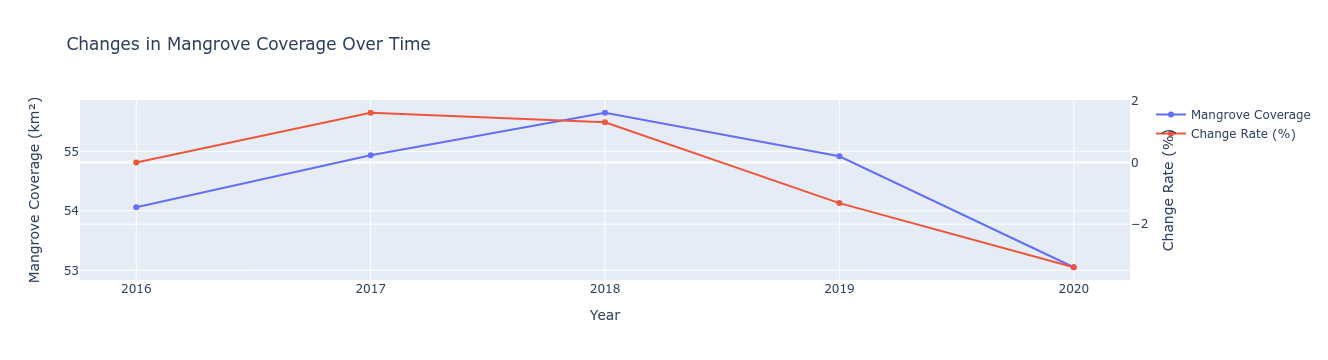

In [10]:
# Create a Plotly figure
fig = go.Figure()

# Add trace for mangrove coverage over time
fig.add_trace(go.Scatter(x=years, y=coverages, mode='lines+markers', name='Mangrove Coverage'))
# Create a second y-axis
fig.add_trace(go.Scatter(x=years, y=change_rates, mode='lines+markers', name='Change Rate (%)', yaxis='y2'))
# Update layout
fig.update_layout(title='Changes in Mangrove Coverage Over Time',
                  xaxis_title='Year',
                  yaxis_title=f'Mangrove Coverage (km\u00b2)',
                  hovermode='closest',
                  xaxis=dict(tickmode='linear', dtick=1),  # Ensure years are displayed as whole numbers
                  yaxis2=dict(title='Change Rate (%)', overlaying='y', side='right')  # Define second y-axis
)

# Show the figure
fig.show()

### c5. Summary

The data illustrates the fluctuation in mangrove coverage over the years 2016 to 2020. Starting from 54.06 km² in 2016, the coverage increased steadily to 55.65 km² by 2018, but then experienced a decline to 53.05 km² by 2020. This pattern suggests both periods of growth and decline in mangrove coverage over the observed timeframe. Moreover, the spatial pattern of mangrove coverage appears to be scattered, indicating variations in the rates and directions of change across different regions. 

The change rate from year to year is relatively modest, ranging from an increase of +1.6% to a decrease of -3.4%. Despite this general trend of low variability, the observed decline in mangrove coverage by 2020 warrants closer examination. It is essential to pinpoint the specific locations where this decline occurred and to investigate potential factors contributing to it. Additionally, conducting thorough assessments can help rule out the possibility of mapping errors, ensuring the accuracy of the findings.

# Case Two: Coastal flood risk datasets and visualisation
The visualisation of each dataset has a zoom in to the same area of interest of Case One.

### [WRI Aqueduct Floods Hazard Maps Version 2](https://developers.google.com/earth-engine/datasets/catalog/WRI_Aqueduct_Flood_Hazard_Maps_V2)
This relatively coarser resolution dataset can be used to evaluate the riverine and coastal food risks under both current baseline conditions and future projections in 2030, 2050, and 2080.

Resolution: 10000 m

The dataset is rich in information. [Click for more info](https://www.wri.org/data/aqueduct-floods-hazard-maps)

In [43]:
aquaduct = (ee.ImageCollection("WRI/Aqueduct_Flood_Hazard_Maps/V2")
                .filter(ee.Filter.eq("climatescenario","rcp4p5")) #Representative Concentration Pathway 4.5 (rising carbon emissions)
                .filter(ee.Filter.eq("floodtype","inuncoast")) #coastal
                .filter(ee.Filter.eq("projection",50)) # Sea level change 50% (medium)
                .filter(ee.Filter.eq("returnperiod",250)) # Flood magnitude (return period in years)
                .filter(ee.Filter.eq("subsidence","nosub")) # Subsidence refers to the lowering of land levels.
                .filter(ee.Filter.eq("year",2030))# Furture year of 2030
                .filterBounds(roi)
           )
print (aquaduct.size().getInfo())

1


## Visualization shows the coastal flood risk under medium level of sea level change risk

In [44]:
m = geemap.Map(center=(lat, lon), zoom=10)

inundationDepthVis = {
  "min": 0,
  "max": 1,
  "palette": ['ffffff','0000ff'],
};
m.add_layer(aquaduct.mosaic().selfMask(), inundationDepthVis, "Coastal flood risk under the medium level of sea level change")

m

Map(center=[5.81621360818146, 0.7511877748750028], controls=(WidgetControl(options=['position', 'transparent_b…

## Annual probablity of flood under this scenario

In [47]:
m = geemap.Map(center=(lat, lon), zoom=10)

inundationDepthVis = {
  "min": 0,
  "max": 10,
  "palette": ['ffffff','red'],
};
m.add_layer(aquaduct.mosaic().selfMask().divide(250).multiply(100), inundationDepthVis, "Annual probablity of flood")

m

Map(center=[5.81621360818146, 0.7511877748750028], controls=(WidgetControl(options=['position', 'transparent_b…

### [Global Flood Database v1 (2000-2018)](https://developers.google.com/earth-engine/datasets/catalog/GLOBAL_FLOOD_DB_MODIS_EVENTS_V1) 
This dataset covers 931 flood events from 2000 to 2018. It is suitable to understand the time, extent and duration of past flood events.

The mapped floodplain aligns well with what WRI map captured, but with higher granularity.

Resolution: 30 m

In [50]:

gfd = ee.ImageCollection('GLOBAL_FLOOD_DB/MODIS_EVENTS/V1')
gfdFloodedSum = gfd.select('flooded').sum();


In [51]:
m = geemap.Map(center=(lat, lon), zoom=10)

Vis = {
  "min": 0,
  "max": 10,
  "palette": ['c3effe', '1341e8', '051cb0', '001133'],
};
m.add_layer(gfdFloodedSum, Vis, "GFD Satellite Observed Flood Plain")

m

Map(center=[5.81621360818146, 0.7511877748750028], controls=(WidgetControl(options=['position', 'transparent_b…

### [JRC Global Surface Water Mapping Layers, v1.4](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_4_GlobalSurfaceWater)

JRC and the other [GLAD](https://glad.umd.edu/dataset/global-surface-water-dynamics) products captures surface water extent and dynamics globally from 1984-2022.

The datasets do not explicitly capture flood event, but can show permannante and seasonal water in detailed spatial-temporal patterns.

The sub-datasets also allow futher analysis at monthly frequency.

Resolution: 30 m.

In [ ]:
jrc = ee.Image('JRC/GSW1_4/GlobalSurfaceWater')